# Single-ancilla ground state preparation via Lindbladians

References:
- Zhiyan Ding, Chi-Fang Chen and Lin Lin  
  Single-ancilla ground state preparation:
  [arXiv:2308.15676 [quant-ph]](https://arxiv.org/abs/2308.15676)

## TFIM damping model, time independent Hamiltonian

In [1]:
import matplotlib.pyplot as plt
import qsimulations as qs
import numpy as np
from qutip import *

In [2]:
taylor_aprox_order = (
    8  # Taylor approximation used for simulating exp(-i*sqrt*(dt)*H_tilde)
)

g = 1  # Couppling coefficient
gamma = 0.1  # Damping parameter

systemSize = 2  # System Hamiltonian
nrAncillas = 2  # Ancilla size
J = systemSize  # Nr of jump operators is equal to the number of lattice elements
systemSize_dim = np.power(2, systemSize)  # Hamiltonian system size


T = 5  # Final time
dt = 0.01  # Time step
time_vec = np.arange(0, T, dt)  # Time vector to simulate on


def H_operator(t = 0):
    H = np.zeros((systemSize_dim, systemSize_dim))
    if systemSize > 1:
        for i in np.arange(1, systemSize, 1):
            H = H - qs.Pauli_array(qs.Z, i, systemSize) @ qs.Pauli_array(
                qs.Z, i + 1, systemSize
            )
        H = H - qs.Pauli_array(qs.Z, systemSize, systemSize) @ qs.Pauli_array(
            qs.Z, 1, systemSize
        )
    for i in np.arange(1, systemSize + 1, 1):
        H = H - g * qs.Pauli_array(qs.X, i, systemSize)
    return Qobj(H)

print(H_operator())

def V_damping(i):
    if i == 0:
        sum = 0
        for j in np.arange(1, J + 1, 1):
            sum = sum + V_damping(j).full().conj().T @ V_damping(j).full()
        return Qobj(-1j * H_operator().full() - 0.5 * sum)

    if i >= 1 and i <= systemSize_dim:
        return Qobj(0.5*np.sqrt(gamma)*
             (
                qs.Pauli_array(qs.X, i, systemSize)
                - 1j * qs.Pauli_array(qs.Y, i, systemSize)
            )
        )
    return 0

QSystem = qs.qsimulations(systemSize, systemSize, nrAncillas)
QSystem.H_op = H_operator
QSystem.V_op = V_damping
QSystem._update_module_varibles()
QSystem._prep_energy_states()

rho_ground = QSystem.rho_ground
rho_highest_en = QSystem.rho_highest_en

Quantum object: dims=[[4], [4]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[-2. -1. -1.  0.]
 [-1.  2.  0. -1.]
 [-1.  0.  2. -1.]
 [ 0. -1. -1. -2.]]


### Exact simulation


/home/robi/.local/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


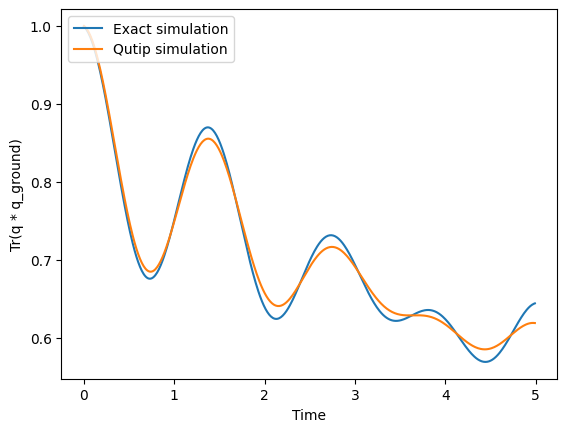

In [16]:
import matplotlib.pyplot as plt
from qutip import mesolve
import numpy as np

rho = QSystem.rho_ground
exact_trace_rho_highest_en = []
for t in time_vec:
    sum = Qobj(np.zeros((QSystem._systemSizeDim, QSystem._systemSizeDim)))
    for j in np.arange(1, J + 1, 1):
        sum = sum + QSystem.V_op(j) @ rho @ QSystem.V_op(j).conj().trans() - 0.5 * (
            QSystem.V_op(j).conj().trans() @ QSystem.V_op(j) @ rho
            + rho @ QSystem.V_op(j).conj().trans() @ QSystem.V_op(j)
        )
    delta_rho = -1j * (QSystem.H_op() @ rho - rho @ QSystem.H_op()) + sum
    rho = rho + dt * delta_rho
    exact_trace_rho_highest_en.append((rho @ QSystem.rho_ground).tr())

V1 = V_damping(1)
V2 = V_damping(2)
results2 = mesolve(QSystem.H_op(), Qobj(QSystem.rho_ground), time_vec, [V1, V2], [QSystem.rho_ground])

plt.figure()
plt.xlabel("Time")
plt.ylabel("Tr(q * q_ground)")
plt.plot(time_vec, exact_trace_rho_highest_en, label="Exact simulation")
plt.plot(time_vec, results2.expect[0], label="Qutip simulation")
plt.legend(loc="upper left")

### First order approximation

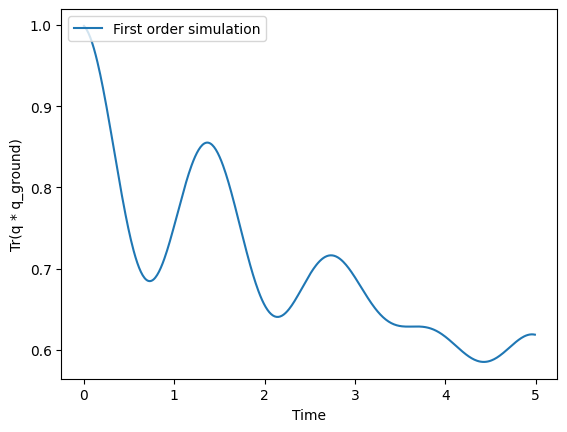

In [4]:
import math
import numpy as np

ancilla = 2  # Ancillary system size
QSystem.set_nr_of_ancillas(ancilla)
ancilla_dim = np.power(2, ancilla)
total_systemSize = systemSize + ancilla  # Total system size
total_systemSize_dim = np.power(2, total_systemSize)
taylor_aproximation_order = 10

# First order scheme
psi_ancilla = 1
for i in range(ancilla):
    psi_ancilla = np.kron(psi_ancilla, qs.ket_0)
rho_ancilla = Qobj(psi_ancilla.conj().T @ psi_ancilla)

rho = QSystem.rho_ground
first_order_trace_rho_highest_en = []
for t in time_vec:
    # Extended system, zero initialized ancilla + hamiltonian system
    system = Qobj(
        tensor(rho_ancilla, rho),
        dims=[[ancilla_dim, systemSize_dim], [ancilla_dim, systemSize_dim]],
    )
    # First element of taylor approximation, I
    approximation = Qobj(
        qeye(ancilla_dim * systemSize_dim),
        dims=[[ancilla_dim, systemSize_dim], [ancilla_dim, systemSize_dim]],
    )

    approximation = qs.Taylor_approximtion(
        QSystem.H_tilde_first_order(dt),
        taylor_aproximation_order,
        np.sqrt(dt),
        approximation,
    )
    evolved_system = approximation @ system @ approximation.conj().trans()

    rho = evolved_system.ptrace(1)
    first_order_trace_rho_highest_en.append((rho @ QSystem.rho_ground).tr())

plt.figure()
plt.xlabel("Time")
plt.ylabel("Tr(q * q_ground)")
plt.plot(time_vec, first_order_trace_rho_highest_en, label="First order simulation")
plt.legend(loc="upper left")

### Second order approximation

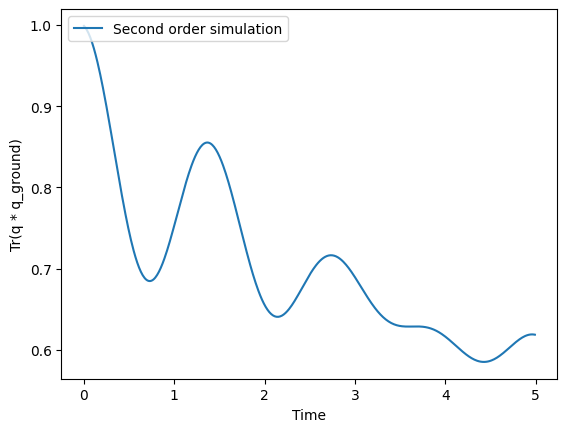

In [5]:
import math
import numpy as np

ancilla = 5  # Ancillary system size
QSystem.set_nr_of_ancillas(ancilla)
ancilla_dim = np.power(2, ancilla)
total_systemSize = systemSize + ancilla  # Total system size
total_systemSize_dim = np.power(2, total_systemSize)
taylor_aproximation_order = 10

# First order scheme
psi_ancilla = 1
for i in range(ancilla):
    psi_ancilla = np.kron(psi_ancilla, qs.ket_0)
rho_ancilla = Qobj(psi_ancilla.conj().T @ psi_ancilla)

rho = rho_ground
second_order_trace_rho_highest_en = []
for t in time_vec:
    # print(t)
    # Extended system, zero initialized ancilla + hamiltonian system
    system = Qobj(
        tensor(rho_ancilla, rho),
        dims=[[ancilla_dim, systemSize_dim], [ancilla_dim, systemSize_dim]],
    )
    # First element of taylor approximation, I
    approximation = Qobj(
        qeye(ancilla_dim * systemSize_dim),
        dims=[[ancilla_dim, systemSize_dim], [ancilla_dim, systemSize_dim]],
    )

    approximation = qs.Taylor_approximtion(
        QSystem.H_tilde_second_order(dt),
        taylor_aproximation_order,
        np.sqrt(dt),
        approximation,
    )
    evolved_system = approximation @ system @ approximation.conj().trans()

    rho = evolved_system.ptrace(1)
    second_order_trace_rho_highest_en.append((rho @ rho_ground).tr())

plt.figure()
plt.xlabel("Time")
plt.ylabel("Tr(q * q_ground)")
plt.plot(time_vec, second_order_trace_rho_highest_en, label="Second order simulation")
plt.legend(loc="upper left")

5


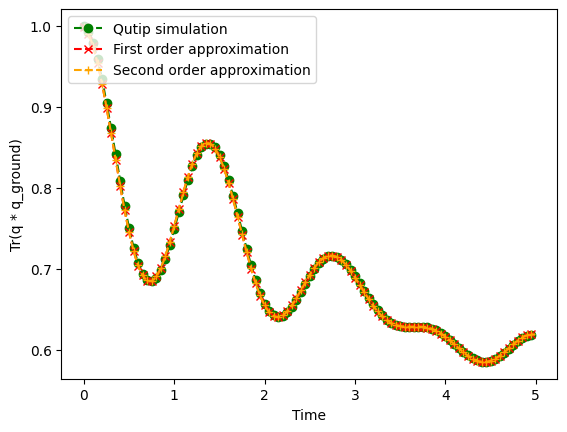

In [7]:
import matplotlib.pyplot as plt

total_nr_of_points = 100
plot_density = (int)(np.size(time_vec) / total_nr_of_points)
print(plot_density)

plt.figure()
plt.xlabel("Time")
plt.ylabel("Tr(q * q_ground)")
# plt.plot(time_vec, exact_trace_rho_highest_en, label="Exact simulation")
plt.plot(
    time_vec,
    results2.expect[0],
    label="Qutip simulation",
    color="green",
    marker="o",
    linestyle="dashed",
    markevery=plot_density,
)
plt.plot(
    time_vec,
    first_order_trace_rho_highest_en,
    label="First order approximation",
    color="red",
    marker="x",
    linestyle="dashed",
    markevery=plot_density,
)
plt.plot(
    time_vec,
    second_order_trace_rho_highest_en,
    label="Second order approximation",
    color="orange",
    marker="+",
    linestyle="dashed",
    markevery=plot_density,
)
plt.legend(loc="upper left")